In [1]:
import pandas as pd
import numpy as np
import toml
from os.path import join
import glob
import create_problem_input as cpi
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

In [ ]:
jobs_max_size = 128
machines_max_size = 16
dir_path = r'../data/auto/'

In [ ]:
sizes = lambda size: [int(2**i) for i in range(1, int(np.log2(size)+1))]
job_sizes = sizes(jobs_max_size)
machine_sizes = sizes(machines_max_size)
conflicting_machines = {
    1: [],
    2: [],
    4: [(1, 2)],
    8: [(1, 2), (5, 7)],
    16: [(1, 2), (5, 7), (9, 10), (13, 14)],
    32: [(1, 2), (5, 7), (9, 10), (13, 14), (15, 16), (17, 18), (20, 25), (27, 30)]
}

for jobs_cnt in job_sizes:
    for machines_cnt in machine_sizes:
        file_name = f'{jobs_cnt}j{machines_cnt}m0'
        csv_file_path = f'{join(dir_path, file_name)}.csv'

        np.savetxt(
            csv_file_path,
            np.random.rand(jobs_cnt, machines_cnt) * 100,
            fmt='%.2f',
            delimiter=',')

        toml_dict = {
            'title': file_name,
            'info': f'{jobs_cnt} jobs {machines_cnt} machines example 0',
            'files':
            {
                'data': csv_file_path,
                'processing_times': csv_file_path
            },
            'problem_data':
            {
                'index_cols': [],
                'grouping_cols': [],
                'conflicting_machines': conflicting_machines[machines_cnt]
            },
            'algorithm_config':
            {
                'beam_witdh': 5
            },
        }

        with open(join(dir_path, f'{file_name}.toml'), 'w') as f:
            f.write(toml.dumps(toml_dict).replace(']', ' ]'))

In [ ]:
glob.glob(r'../data/auto/*.toml')

In [9]:
op_times_df = (
    pd.read_csv('testing_times.csv', usecols=['0','1','2'])
    .rename(columns={'0': 'file', '1': 'prep_time', '2': 'max_end_time'})
)
op_times_df

,file,prep_time,max_end_time
0,../data/auto\128j16m0.toml,4523.627438,972069.0
1,../data/auto\128j2m0.toml,431.677663,824552.0
2,../data/auto\128j4m0.toml,1006.711800,882949.0
3,../data/auto\128j8m0.toml,1934.950913,909126.0
4,../data/auto\16j16m0.toml,1.690686,143070.0
5,../data/auto\16j2m0.toml,0.205009,109056.0
6,../data/auto\16j4m0.toml,0.437964,115703.0
7,../data/auto\16j8m0.toml,0.896021,133131.0
8,../data/auto\2j16m0.toml,0.005046,19867.0
9,../data/auto\2j2m0.toml,0.001276,7103.0


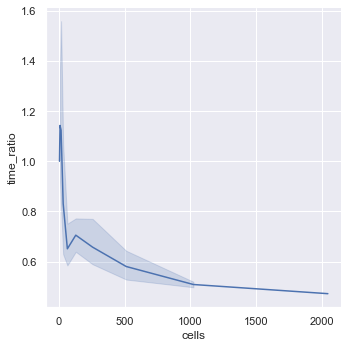

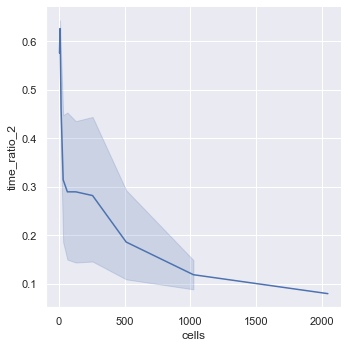

In [22]:
def calc_stupid_time(row, conflicts):
    l = []
    # mc = max([row[c1] + row[c2] for c1, c2 in conflicts])
    # return max((max(row), max([row[c1] + row[c2] for c1, c2 in conflicts]), 0))
    for c1, c2 in conflicts:
        l.append(row[c1] + row[c2])
    l.append(max(row))
    return max(l)

op_times_df['jobs'] = op_times_df['file'].str.extract(r'^[^\d]+(\d+)j.*$').astype(np.int)
op_times_df['machines'] = op_times_df['file'].str.extract(r'^[^\d]+\d+j(\d+)m.*$').astype(np.int)
op_times_df['cells'] = op_times_df.jobs * op_times_df.machines
op_times_df['primitive_time'] = 0
op_times_df['seq_op_time'] = 0

for idx, o in op_times_df.iterrows():
    pf = o.file
    # print(pf)
    pi = cpi.ProblemInput.from_toml(pf)
    op_times_df.loc[idx, 'primitive_time'] = sum(pi.processing_times.apply(lambda r: calc_stupid_time(r, pi.conflicting_machines_list), axis=1))
    op_times_df.loc[idx, 'seq_op_time'] = sum(pi.processing_times.apply(lambda r: r.sum(), axis=1))

op_times_df['time_ratio'] = op_times_df.max_end_time / op_times_df.primitive_time
op_times_df['time_ratio_2'] = op_times_df.max_end_time / op_times_df.seq_op_time
op_times_df.sort_values('cells')

g = sns.relplot(x="cells", y="time_ratio", data=op_times_df, kind="line",)
g = sns.relplot(x="cells", y="time_ratio_2", data=op_times_df, kind="line",)


In [ ]:
g = sns.relplot(x="machines", y="prep_time", data=op_times_df[op_times_df.jobs==128], kind="line",)
# g.fig.autofmt_xdate()

In [ ]:
g = sns.relplot(x="jobs", y="prep_time", data=op_times_df[op_times_df.machines==16], kind="line",)
# g.fig.autofmt_xdate()